In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Prepare plotting.

In [19]:
%matplotlib inline

In [20]:
def view_frame(T, ax=None, length=0.1):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(projection="3d")
    orig = np.array([0, 0, 0, 1])
    xx = np.array([length, 0, 0, 1])
    yy = np.array([0, length, 0, 1])
    zz = np.array([0, 0, length, 1])
    points = np.vstack([orig, xx, yy, zz]).T

    points_ = T @ points
    xaxis = points_[:3, [0, 1]]
    yaxis = points_[:3, [0, 2]]
    zaxis = points_[:3, [0, 3]]

    ax.plot(*xaxis, color="r")
    ax.plot(*yaxis, color="g")
    ax.plot(*zaxis, color="b")

In [21]:
def make_new_figure():
    fig = plt.figure()
    ax = fig.add_subplot(projection="3d")
    ax.set_xlim([-1, 1])
    ax.set_ylim([-1, 1])
    ax.set_zlim([0, 1])
    view_frame(np.eye(4), ax=ax)
    return ax

### Two frame

In [22]:
def make_transformation_matrix(R, t):
    t = np.array(t) #ensure t is np.ndarray
    if len(t.shape) == 1:
        t = t[:,None]
    return np.block([[R,t], [0,0,0,1]])

In [23]:
# make random rotation using qr decomposition
np.random.seed(4)

# if you want to make random rotation, use code below
#  R = np.linalg.qr(np.random.random((3,3)))[0]
a = 0.001
a1 = np.sqrt(1 - a**2)
R1 = np.array([
    [0, 0, 1],
    [0, 1, 0],
    [-1, 0, 0]
])

R2 = np.array([
    [-1/np.sqrt(2),0,1/np.sqrt(2)],
    [0, 1, 0],
    [-1/np.sqrt(2), 0, -1/np.sqrt(2)]
])

# if you want to make random position, use code below
#  np.random.uniform(low=[-1,-1,0], high=[1,1,1])
t1 = np.array([-0.5, -0.5, 0.7]) 
t2 = np.array([-0.5, 0.8, 0.7]) 

# make transformation matrices
T1 = make_transformation_matrix(R1, t1)
T2 = make_transformation_matrix(R2, t2)

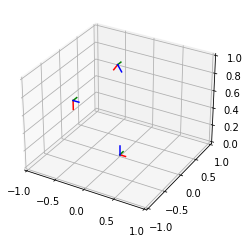

In [24]:
ax = make_new_figure()
view_frame(T1, ax=ax)
view_frame(T2, ax=ax)

### SE3 interpolation

In [25]:
def skew(x):
    x = np.array(x)
    return np.array(
        [[0    , -x[2], x[1] ],
         [x[2] , 0    , -x[0]],
         [-x[1], x[0] , 0    ]]
    )

def inv_SE3(T):
    """ make inverse of transformation matrix
    """
    R_inv = T[:3,:3].T
    t_inv = -R_inv@T[:3,-1]
    return make_transformation_matrix(R_inv, t_inv)

def exp_SO3(axis, angle):
    if angle == 0.:
        return np.eye(3)
    axis_norm = np.linalg.norm(axis)
    if axis_norm != 1.:
        axis = axis/axis_norm
    theta = angle
    omega_hat = axis
    return np.eye(3) \
       + np.sin(theta) * skew(omega_hat) \
       + (1-np.cos(theta)) * skew(omega_hat) @ skew(omega_hat)
    
def log_SO3(R):
    """ make rotation matrix(SO3) to axis-angle(so3, exponential coordinate) representation
    """
    if np.allclose(R, np.eye(3)):
        # no rotation
        axis = np.array([1., 0., 0.])
        angle = 0.
    elif np.trace(R) == -1:
        # angle is 180 degrees
        angle = np.pi
        if R[0,0] != -1:
            axis = 1/np.sqrt(2*(1+R[0,0])) * np.array([1+R[0,0], R[1,0], R[2,0]])
        elif R[1,1] != -1:
            axis = 1/np.sqrt(2*(1+R[1,1])) * np.array([R[0,1], 1+R[1,1], R[2,1]])
        else:
            axis = 1/np.sqrt(2*(1+R[2,2])) * np.array([R[0,2], R[1,2], 1+R[2,2]])
    else:
        angle = np.arccos(1/2*(np.trace(R)-1))
        axis = 1/(2*np.sin(angle))*np.array([R[2,1]-R[1,2], R[0,2]-R[2,0], R[1,0]-R[0,1]])
    return axis, angle

def exp_SE3(screw, angle):
    omega, v = screw[:3], screw[3:]
    theta = angle
    G = np.eye(3)*theta \
        + (1-np.cos(theta))*skew(omega) \
        + (theta-np.sin(theta))*skew(omega)@skew(omega)

    if np.linalg.norm(omega) == 0:
        R = np.eye(3)
        t = v*theta
    else:
        R = exp_SO3(omega, theta)
        t = G @ v

    return make_transformation_matrix(R, t)
    
def log_SE3(T):
    """ make transformation matrix(SE3) to screw-angle(se3) representation
    """
    R, t = T[:3,:3], T[:3,-1]
    if np.allclose(T, np.eye(4)):
        screw = np.array([1.,0.,0.,0.,0.,0])
        theta = 0
    elif np.allclose(R, np.eye(3)):
        # pure translation
        omega = np.zeros(3)
        theta = np.linalg.norm(t)
        v = t/theta
        screw = np.hstack([omega, v])
    else:
        omega, theta = log_SO3(R)
        Ginv = 1/theta * np.eye(3) \
               - 1/2 * skew(omega) \
               + (1/theta-1/2/np.tan(theta/2)) * skew(omega) @ skew(omega)
        v = Ginv.dot(t)
        screw = np.hstack([omega, v])
    return screw, theta

In [26]:
n = 10

In [27]:
screw, angle = log_SE3(inv_SE3(T1)@T2)
T_interp_list = []
for interp_ratio in np.linspace(0, 1, n):
    T_interp = T1 @ exp_SE3(screw, angle*interp_ratio)
    T_interp_list.append(T_interp)

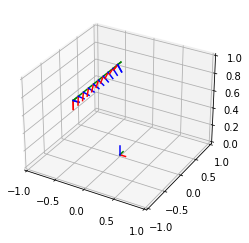

In [28]:
# plot
ax = make_new_figure()
view_frame(T1, ax=ax)
view_frame(T2, ax=ax)

for T in T_interp_list:
    view_frame(T, ax=ax)

### R(exp.coord.), t interpolation

In [29]:
n = 10

In [30]:
axis, angle = log_SO3(R1.T@R2)
T_interp_list = []
for interp_ratio in np.linspace(0, 1, n):
    R_interp = R1 @ exp_SO3(axis, angle*interp_ratio)
    t_interp = t1 + (t2 - t1) * interp_ratio
    T_interp = make_transformation_matrix(R_interp, t_interp)
    T_interp_list.append(T_interp)

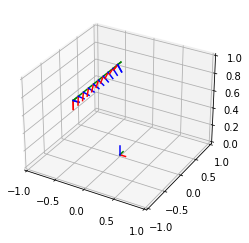

In [31]:
# plot
ax = make_new_figure()
view_frame(T1, ax=ax)
view_frame(T2, ax=ax)

for T in T_interp_list:
    view_frame(T, ax=ax)

### R(euler rpy), t interpolation

In [32]:
def SO3_to_euler_rpy(R):
    yaw = np.arctan2(R[1,0], R[0,0])
    pitch = np.arctan2(-R[2,0], np.sqrt(R[2,1]**2 + R[2,2]**2))
    roll = np.arctan2(R[2,1], R[2,2])
    return np.array([yaw, pitch, roll])
    
def euler_rpy_to_SO3(ypr):
    yaw, pitch, roll = ypr
    r11 = np.cos(yaw)*np.cos(pitch)
    r21 = np.sin(yaw)*np.cos(pitch)
    r31 = -np.sin(pitch)
    r12 = np.cos(yaw)*np.sin(pitch)*np.sin(roll) - np.sin(yaw)*np.cos(roll)
    r22 = np.sin(yaw)*np.sin(pitch)*np.sin(roll) + np.cos(yaw)*np.cos(roll)
    r32 = np.cos(pitch)*np.sin(roll)
    r13 = np.cos(yaw)*np.sin(pitch)*np.cos(roll) + np.sin(yaw)*np.sin(roll)
    r23 = np.sin(yaw)*np.sin(pitch)*np.cos(roll) - np.cos(yaw)*np.sin(roll)
    r33 = np.cos(pitch)*np.cos(roll)
    return np.array([
        [r11, r12, r13],
        [r21, r22, r23],
        [r31, r32, r33]
    ])

In [33]:
n = 10

In [34]:
ypr1 = SO3_to_euler_rpy(R1)
ypr2 = SO3_to_euler_rpy(R2) 
T_interp_list = []
ypr_interp_list = []
for interp_ratio in np.linspace(0, 1, n):
    ypr_interp = ypr1 + (ypr2 - ypr1) * interp_ratio
    ypr_interp_list.append(ypr_interp)
    R_interp = euler_rpy_to_SO3(ypr_interp)
    t_interp = t1 + (t2 - t1) * interp_ratio
    T_interp = make_transformation_matrix(R_interp, t_interp)
    T_interp_list.append(T_interp)

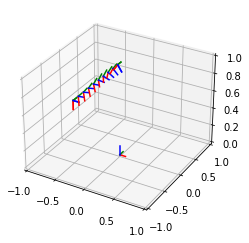

In [35]:
# plot
ax = make_new_figure()
view_frame(T1, ax=ax)
view_frame(T2, ax=ax)

for T in T_interp_list:
    view_frame(T, ax=ax)